### 메타 필터링 통해서 api 주제 필터링하여 벡터 db 검색 + 질문 의도 분류 및 멀티모달 적용된 langgraph

- 메타 필터링 외에 rag 자체에서 변경된 사항은 질문 의도 분류 및 멀티모달인데, 질문 의도 분류 및 멀티모달은 rag 평가에 사용하지 않기 때문에 메타 필터링만 달라진 것으로 체크함

In [2]:
from pathlib import Path
import sys

root = Path.cwd()
while not (root / "utils_3").exists() and root != root.parent:
    root = root.parent
sys.path.insert(0, str(root))

from utils_3.main3 import run_langraph

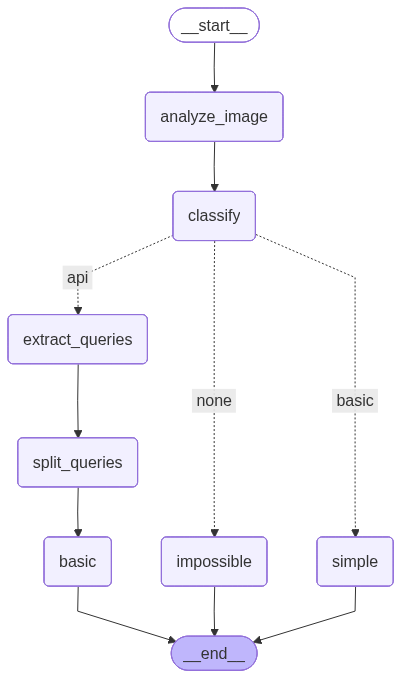

In [3]:
from utils_3.langgraph_setting2 import graph_setting

graph = graph_setting()

graph

## None 은 이미지 url 없기 때문에 설정한 것

In [4]:
response = run_langraph('people api 알려줘', '1', None)
print(response)

run_langraph 호출 - 입력: people api 알려줘, 이미지: False
analyze_image 호출됨 - 이미지 존재: False
생성된 질문 리스트 ['People API에 대해 알려주세요.']
People API에 대해 알려주세요. 검색중...
사용자 통합 질문: people api 알려줘
그래프 실행 결과: {'question': 'people api 알려줘', 'answer': "People API는 Google의 연락처 및 사용자 프로필 정보를 관리할 수 있는 API입니다. 이 API를 사용하면 인증된 사용자의 연락처를 읽고 관리할 수 있으며, '기타 연락처'를 읽고 복사할 수 있습니다. 또한, 인증된 사용자 및 사용자 연락처의 프로필 정보를 읽을 수 있습니다.\n\nPeople API는 HTTP 및 JSON에 기반하고 있어 모든 표준 HTTP 클라이언트를 통해 요청을 보내고 응답을 파싱할 수 있습니다. 다양한 프로그래밍 언어에 대한 클라이언트 라이브러리를 제공하여 API 요청을 보다 쉽게 통합하고 보안을 강화할 수 있습니다.\n\n예를 들어, 특정 사람의 정보를 가져오려면 `people.get` 메서드를 호출하고 리소스 이름을 전달하여 그 사람의 정보를 가져올 수 있습니다. 새로운 연락처를 만들거나 기존 연락처를 업데이트하고 삭제하는 등의 작업도 가능합니다.\n\n자세한 내용은 [People API 문서](https://developers.google.com/people?hl=ko)를 참고하세요.", 'rewritten': [{'role': 'user', 'content': 'people api 알려줘'}], 'queries': ['People API에 대해 알려주세요.'], 'search_results': [[Document(id='746b9903-aa7e-4975-9500-e5cfc38078b9', metadata={'last_verified': '2025-08-19', 'source': 'https://developers.go

In [5]:
print(response['answer'])

People API는 Google의 연락처 및 사용자 프로필 정보를 관리할 수 있는 API입니다. 이 API를 사용하면 인증된 사용자의 연락처를 읽고 관리할 수 있으며, '기타 연락처'를 읽고 복사할 수 있습니다. 또한, 인증된 사용자 및 사용자 연락처의 프로필 정보를 읽을 수 있습니다.

People API는 HTTP 및 JSON에 기반하고 있어 모든 표준 HTTP 클라이언트를 통해 요청을 보내고 응답을 파싱할 수 있습니다. 다양한 프로그래밍 언어에 대한 클라이언트 라이브러리를 제공하여 API 요청을 보다 쉽게 통합하고 보안을 강화할 수 있습니다.

예를 들어, 특정 사람의 정보를 가져오려면 `people.get` 메서드를 호출하고 리소스 이름을 전달하여 그 사람의 정보를 가져올 수 있습니다. 새로운 연락처를 만들거나 기존 연락처를 업데이트하고 삭제하는 등의 작업도 가능합니다.

자세한 내용은 [People API 문서](https://developers.google.com/people?hl=ko)를 참고하세요.


In [ ]:
## 환경설정
!pip install -qU ragas langchain langchain-community langchain-openai langchain-chroma langchain-text-splitters pypdf rapidfuzz langgraph gdown chromadb langchain-huggingface sentence-transformers -q

In [6]:
import os
from dotenv import load_dotenv

load_dotenv()
# 필요한 라이브러리 임포트
import os
import pandas as pd
from pprint import pprint
# LangChain 관련 라이브러리
from langchain_community.document_loaders import TextLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_chroma import Chroma
from langchain_openai import OpenAIEmbeddings, ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser
# RAGAS 관련 라이브러리
from ragas.llms import LangchainLLMWrapper
from ragas.embeddings import LangchainEmbeddingsWrapper
from ragas.testset.persona import Persona
from ragas.testset import TestsetGenerator
from ragas import EvaluationDataset, evaluate
from ragas.metrics import LLMContextRecall, Faithfulness, FactualCorrectness

In [8]:
# 벡터 DB 다운로드 실행 (없으면 retriever.py에서 감지하고 자동 다운로드 함)

from pathlib import Path
import sys

# utils_1까지의 루트 잡기
root = Path.cwd()
while not (root / "utils_3").exists() and root != root.parent:
    root = root.parent
sys.path.insert(0, str(root))

# utils_1 안의 chroma_db 폴더 경로
DB_PATH = root / "utils_3" / "chroma_db"

from langchain_huggingface import HuggingFaceEmbeddings
from langchain_chroma import Chroma

# 임베딩 모델 초기화 // HuggingFaceEmbeddings
embedding_model = HuggingFaceEmbeddings(
    model_name="BAAI/bge-m3",
    encode_kwargs={"normalize_embeddings": True},
)

vector_store = Chroma(
    embedding_function=embedding_model,
    collection_name="google_api_docs",
    persist_directory=str(DB_PATH),
)

print(f"벡터 DB 로드 완료. 저장된 Document 개수: {len(vector_store.get()['ids'])}")

벡터 DB 로드 완료. 저장된 Document 개수: 28860


In [9]:
# 벡터 DB 내용 확인
db_contents = vector_store.get(
    include=['metadatas', 'documents']
)

print("### 벡터 DB의 첫 3개 문서 내용 ###")
for i in range(3):
    print("--- 문서", i + 1, "---")
    print("내용:", db_contents['documents'][i])
    print("메타데이터:", db_contents['metadatas'][i])
    print("-" * 20)

### 벡터 DB의 첫 3개 문서 내용 ###
--- 문서 1 ---
내용: Source URL: https://developers.google.com/workspace/drive/api/reference/rest/v3/User?hl=ko

이 페이지는 Cloud Translation API [https://cloud.google.com/translate/?hl=ko]를 통해 번역되었습니다.
Switch to English
홈 [https://developers.google.com/?hl=ko]
Google Workspace [https://developers.google.com/workspace?hl=ko]
Google Drive [https://developers.google.com/workspace/drive?hl=ko]
참조 [https://developers.google.com/workspace/drive/api/reference/rest/v3?hl=ko]
의견 보내기
User
bookmark_border
Drive 사용자에 관한 정보입니다.
JSON 표현
{
  "displayName": string,
  "kind": string,
  "me": boolean,
  "permissionId": string,
  "emailAddress": string,
  "photoLink": string
}
필드
displayName
string
출력 전용입니다. 이 사용자의 표시 가능한 일반 텍스트 이름입니다.
kind
string
출력 전용입니다. 리소스 종류를 식별합니다. 값: 고정 문자열 drive#user.
me
boolean
출력 전용입니다. 이 사용자가 요청하는 사용자인지 여부입니다.
permissionId
string
출력 전용입니다. 권한 리소스에 표시되는 사용자의 ID입니다.
emailAddress
string
출력 전용입니다. 사용자의 이메일 주소입니다. 사용자가 요청자에게 이메일 주소를 표시하지 않은 경우 특정 컨텍스트에 표시되지 않을 수

## 이미 만들어진 데이터셋 사용 시 스킵

In [10]:
### 합성 데이터셋 생성

from ragas.testset.persona import Persona

# 페르소나 정의
personas = [
    Persona(
        name="expert",
        role_description="최신 구글 API에 대해 박식한 전문가. 한국어 사용자",
    ),
    Persona(
        name="beginner",
        role_description="구글 API에 대해 잘 모르는 일반 사용자. 한국어 사용자",
    ),
]
# LLM과 임베딩 모델 초기화
generator_llm = LangchainLLMWrapper(ChatOpenAI(model="gpt-4.1"))
generator_embeddings = HuggingFaceEmbeddings(
    model_name="BAAI/bge-m3",
    encode_kwargs={"normalize_embeddings": True},
)
# TestsetGenerator 생성
generator = TestsetGenerator(
    llm=generator_llm,
    embedding_model=generator_embeddings,
    persona_list=personas
)
# 데이터셋 생성
from ragas.testset.synthesizers.single_hop.specific import (
    SingleHopSpecificQuerySynthesizer,  # 특정 정보에 대한 직접적인 질의를 생성하는 합성기
)

distribution = [
    (SingleHopSpecificQuerySynthesizer(llm=generator_llm), 1.0),
]

for query, _ in distribution:
    prompts = await query.adapt_prompts("korean", llm=generator_llm)  # 프롬프트 언어 설정(한국어)
    query.set_prompts(**prompts)
from ragas.testset.transforms.extractors.llm_based import NERExtractor
from ragas.testset.transforms.splitters import HeadlineSplitter

# HeadlineSplitter(),
transforms = [NERExtractor()]
import random
from langchain_core.documents import Document

all_documents = vector_store.get(include=['documents', 'metadatas'])

# LangChain Document 객체 리스트로 변환
docs = [
    Document(page_content=doc_content, metadata=doc_metadata)
    for doc_content, doc_metadata in zip(all_documents['documents'], all_documents['metadatas'])
]

random.shuffle(docs)
sampled_docs = docs[:30]
# 30개의 합성 데이터셋 생성
dataset = generator.generate_with_langchain_docs(
    documents=sampled_docs,
    testset_size=20,
    transforms=transforms,
    query_distribution=distribution,
)

print("합성 데이터셋 생성 완료")
# 데이터셋을 DataFrame으로 변환
import pandas as pd

pd.set_option('display.max_colwidth', None)

dataset_df = dataset.to_pandas()
display(dataset_df)

# single_hop_specific_query_synthesizer: RAGAS 라이브러리에 내장된 **'질의 합성기(query synthesizer)'**의 한 종류
# 역할: 주어진 문서(컨텍스트)에서 하나의 문서(청크)만으로 답변할 수 있는 구체적인 질문을 자동으로 생성하는 역할
# CSV 파일로 저장

dataset_df.to_csv('./ragas_dataset.csv', index=False)


Applying NERExtractor:   0%|          | 0/30 [00:00<?, ?it/s]

Generating Scenarios:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Samples:   0%|          | 0/20 [00:00<?, ?it/s]

합성 데이터셋 생성 완료


,user_input,reference_contexts,reference,synthesizer_name
0,CSV 파일을 이용해서 S/MIME 인증서를 관리하려면 어떤 작업이 필요한가요?,"[Q: S/MIME 인증서를 관리하기 위해 CSV 파일을 처리하는 함수에서 어떤 작업을 수행해야 하나요?\nA: S/MIME 인증서를 관리하기 위해 CSV 파일을 처리하는 함수에서는 사용자의 인증서를 나열하고, 기본 인증서가 만료되었거나 설정되지 않은 경우 지정된 파일에서 인증서를 업로드해야 합니다. 그런 다음 만료일이 가장 늦은 인증서를 기본값으로 설정하는 작업을 수행해야 합니다.]","CSV 파일을 처리하는 함수에서는 사용자의 인증서를 나열하고, 기본 인증서가 만료되었거나 설정되지 않은 경우 지정된 파일에서 인증서를 업로드해야 합니다. 그리고 만료일이 가장 늦은 인증서를 기본값으로 설정하는 작업을 해야 합니다.",single_hop_specific_query_synthesizer
1,클라우드 파이어스토어 부하 분산기 어떻게 써야되나요?,[Q: Cloud Firestore의 부하 분산 기능은 어떻게 작동하나요?\nA: Cloud Firestore는 데이터베이스에 대한 트래픽을 지원하기 위해 자동으로 확장되므로 부하 분산기를 실행할 필요가 없습니다.],Cloud Firestore는 데이터베이스에 대한 트래픽을 지원하기 위해 자동으로 확장되므로 부하 분산기를 실행할 필요가 없습니다.,single_hop_specific_query_synthesizer
2,범위 많으면 동의 어렵나요?,[Q: OAuth 2.0을 사용할 때 요청하는 범위의 수가 사용자 동의에 미치는 영향은 무엇인가요?\nA: 범위를 사용 설정하면 애플리케이션은 필요한 리소스에 대한 액세스만 요청하고 사용자는 애플리케이션에 부여하는 액세스 양을 제어할 수 있습니다. 따라서 요청된 범위 수와 사용자 동의를 얻을 가능성 간에 역관계가 있을 수 있습니다. OAuth 2.0 승인을 구현하기 전에 앱에서 액세스 권한이 필요한 범위를 지정하는 것이 좋습니다.],요청된 범위 수가 많으면 사용자 동의를 얻을 가능성이 낮아질 수 있습니다.,single_hop_specific_query_synthesizer
3,"As a beginner who is not familiar with Google APIs, could you please explain in detail how the Cloud Platform is affected when Google Cloud session control features are enabled, and what specific user actions or applications are impacted by these policies?","[Q: Google Cloud 세션 제어 기능이란 무엇이며, 어떤 영향을 미치나요?\nA: GCP 조직의 관리자는 Google Cloud 세션 제어 기능을 사용하여 사용자가 GCP 리소스에 액세스하는 동안 사용자의 재인증을 자주 요구할 수 있습니다. 이 정책은 Google Cloud Console, Google Cloud SDK (gcloud CLI라고도 함), Cloud Platform 범위가 필요한 서드 파티 OAuth 애플리케이션에 대한 액세스에 영향을 미칩니다.]","When Google Cloud session control features are enabled, administrators in a GCP organization can require users to re-authenticate more frequently while accessing GCP resources. This policy affects access to the Google Cloud Console, the Google Cloud SDK (also known as gcloud CLI), and third-party OAuth applications that require Cloud Platform scopes.",single_hop_specific_query_synthesizer
4,"firebase_functions 어떻게 쓰는지 잘 모르겠는데, Cloud Firestore에서 문서 바뀔 때마다 자동으로 뭔가 실행되게 하려면 firebase_functions에서 뭘 써야 되고, 예시 코드도 보여줄 수 있나요?","[Q: Cloud Firestore에서 특정 문서의 모든 변경에 대해 이벤트를 트리거하려면 어떤 함수를 사용해야 하나요?\nA: 특정 문서의 모든 변경에 이벤트를 트리거하려면 `onDocumentWritten` 함수를 사용해야 합니다. 예시는 다음과 같습니다.\n\n```python\nfrom firebase_functions.firestore_fn import (\n on_document_written,\n Event,\n Change,\n DocumentSnapshot,\n)\n\n@on_document_written(document=""users/marie"")\ndef myfunction(event: Event[Change[DocumentSnapshot]]) -> None:\n # Get an object with the current document values.\n # If the document does not exist, it was deleted.\n document = (event.data.after.to_dict()\n if event.data.after is not None else None)\n\n # Get an object with the previous document values.\n # If the document does not exist, it was newly created.\n previous_values = (event.data.before.to_dict()\n if event.data.before is not None else None)\n\n # Perform more operations ...\n```]","Cloud Firestore에서 특정 문서의 모든 변경에 이벤트를 트리거하려면 onDocumentWritten 함수를 사용해야 합니다. 예시는 다음과 같습니다.\n\nfrom firebase_functions.firestore_fn import (\n on_document_written,\n Event,\n Change,\n DocumentSnapshot,\n)\n\n@on_document_written(document=""users/marie"")\ndef myfunction(event: Event[Change[DocumentSnapshot]]) -> None:\n # Get an object with the current document values.\n # If the document does not exist, it was deleted.\n document = (event.data.after.to_dict()\n if event.data.after is not None else None)\n\n # Get an object with the previous document values.\n # If the document does not exist, it was newly created.\n previous_values = (event.data.before.to_dict()\n if event.data.before is not None else None)\n\n # Perform more operations ...",single_hop_specific_query_synthesizer
5,"Firebase에서 다단계 인증(MFA)을 사용할 때 Objective-C로 사용자 인증을 완료하는 방법과 관련된 코드 예시가 궁금합니다. 어떤 방식으로 인증 정보를 가져오고, Objective-C에서는 어떻게 구현하나요?","[Q: 다단계 인증(MFA) 사용 시 Firebase에서 사용자 인증을 완료하는 방법은 무엇인가요?\nA: 다단계 인증(MFA) 사용 시 Firebase에서 사용자 인증을 완료

## 이미 생성된 합성 데이터셋 생성

In [10]:
import pandas as pd

# 같은 폴더(현재 작업 디렉토리)에 저장했다면
dataset_df = pd.read_csv("./dataset.csv")
print(dataset_df.shape)
display(dataset_df)

(20, 3)


,user_input,reference_contexts,reference
0,Analytics Hub 게시자와 목록 관리자 역할의 차이점은 무엇인가요?,사용자가 다음 작업을 수행할 수 있게 해주는 Analytics Hub 게시자 역할(...,"Analytics Hub 게시자 역할은 목록을 생성, 업데이트, 삭제하고 목록에 I..."
1,BigQuery Studio 저장된 쿼리에 공개 액세스 권한을 방지하려면 어떻게 해...,BigQuery Studio 저장된 쿼리에 공개 액세스 권한이 부여되지 않도록 하려...,BigQuery Studio 저장된 쿼리에 공개 액세스 권한을 방지하려면 프로젝트에...
2,calendarId에 primary 키워드를 사용하면 어떤 캘린더에 접근할 수 있나요?,현재 로그인한 사용자의 기본 캘린더에 액세스하려면 'primary' 키워드를 사용하세요.,calendarId에 primary 키워드를 사용하면 현재 로그인한 사용자의 기본 ...
3,Google Drive API v3의 서비스 엔드포인트가 궁금해,"이 서비스에는 다음 서비스 엔드포인트가 포함되고, 그 아래의 모든 URI가 이 서비...",Google Drive API v3의 서비스 엔드포인트는 https://www.go...
4,files.create 메서드의 최대 파일 크기와 허용되는 미디어 MIME 유형은 ...,"최대 파일 크기: 5,120GB\n허용되는 미디어 MIME 유형: */*\n(리터럴...","files.create 메서드의 최대 파일 크기는 5,120GB입니다. 허용되는 미..."
5,Firebase scrypt 해시 비밀번호를 사용한 사용자 가져오는 방법은?,기본적으로 Firebase는 scrypt 해싱 알고리즘의 수정된 Firebase 버...,"Firebase scrypt 해시 비밀번호를 사용한 사용자를 가져오려면, 먼저 Fi..."
6,커스텀 인증 시스템으로 Firebase에 인증하려면 어떻게 해야 하나요?,Firebase 인증에 맞춤 인증 시스템을 통합할 수 있습니다. 사용자가 정상적으로...,"커스텀 인증 시스템으로 Firebase에 인증하려면, 먼저 인증 서버에서 사용자의 ..."
7,"Firestore에서 맵 필드에 대한 단일 필드 색인 예외를 설정하면, 하위 필드들...",맵 필드에 단일 필드 색인 예외를 만들면 맵의 하위 필드에서 해당 설정을 상속합니다...,"네, Firestore에서 맵 필드에 단일 필드 색인 예외를 만들면 맵의 하위 필드..."
8,Firebase의 updateTime 필드에 사용되는 시간 형식이 뭐야?,"Uses RFC 3339, where generated output will alw...",Firebase의 updateTime 필드에는 RFC 3339 시간 형식이 사용됩니...
9,Firefox 58 환경에서 Gmail의 AMP 렌더링 기능이 호환되나요?,브라우저 최소 버전\nChrome 69\nEdge 지원되지 않음\nFirefox 5...,"네, Firefox 58 환경에서는 Gmail의 AMP 렌더링 기능이 호환됩니다. ..."


In [12]:

## 02.RAG 체인 구성

import pandas as pd
from datasets import Dataset
import uuid

evaluated_dataset = []

for _, row in dataset_df.iterrows():
    query = row.user_input  # 사용자 입력 - 합성 데이터셋에서 가져옴

    # run_langraph 함수 호출
    rag_result = run_langraph(query,'1',None)

    evaluated_dataset.append(
        {
            "user_input": query,
            "retrieved_contexts": [doc.page_content for docs_list in rag_result["search_results"] for doc in
                                   docs_list],
            "response": rag_result["answer"],
            "reference": row['reference']
        }
    )

print("평가 데이터셋 준비 완료")

# RAGAS 평가 데이터셋 생성
ragas_evaluated_dataset = Dataset.from_list(evaluated_dataset)
# csv 데이터 저장
ragas_evaluated_dataset.to_pandas().to_csv('ragas_evaluated_dataset3.csv', index=False)
ragas_evaluated_dataset.to_pandas().info()

run_langraph 호출 - 입력: Analytics Hub 게시자와 목록 관리자 역할의 차이점은 무엇인가요?, 이미지: False
analyze_image 호출됨 - 이미지 존재: False
답변 불가 노드 시작
그래프 실행 결과: {'question': 'Analytics Hub 게시자와 목록 관리자 역할의 차이점은 무엇인가요?', 'answer': '(Analytics Hub 역할의 차이점)은 제가 모르는 내용입니다. 일상 질문 혹은 구글 API 관련 질문만 답변드릴 수 있어요.', 'rewritten': [{'role': 'user', 'content': 'People API의 RequestMask 필드에 무엇을 입력해야 하나요?'}], 'queries': ['People API의 RequestMask 필드에 무엇을 입력해야 하나요?'], 'search_results': [[Document(id='803711c4-93c1-45d1-a75c-6fc95265bc32', metadata={'chunk_id': 42, 'source': 'https://developers.google.com/maps/documentation/navigation/ios-sdk/reference/objc/Classes', 'tags': 'map', 'source_file': 'maps_documentation_navigation_ios-sdk_reference_objc_Classes.txt', 'last_verified': '2025-08-19'}, page_content='GMSProjection [https://developers.google.com/maps/documentation/navigation/ios-sdk/reference/objc/Classes/GMSProjection]\nDefines a mapping between Earth coordinates CLLocationCoordinate2D and coordinates in the map’s view CGPoin

In [12]:
import openai

openai.api_request_timeout = 60  # 타임아웃 시간을 60초로 설정

evaluator_llm = ChatOpenAI(model="gpt-4.1", temperature=0)
evaluator_llm = LangchainLLMWrapper(evaluator_llm)

In [13]:
### RAGAS 평가 실행

# LLM 래퍼 생성
evaluator_llm = ChatOpenAI(model="gpt-4.1-mini", temperature=0)
evaluator_llm = LangchainLLMWrapper(evaluator_llm)

# 평가 메트릭 정의
metrics = [
    LLMContextRecall(),  # 검색된 컨텍스트의 회수율
    Faithfulness(),  # 생성된 답변의 충실도
    FactualCorrectness()  # 사실적 정확성
]
# 평가 실행

result = evaluate(
    dataset=ragas_evaluated_dataset,
    metrics=metrics,
    llm=evaluator_llm,
)

print(result)
# 결과를 DataFrame으로 변환
result_df = result.to_pandas()

# 결과 저장
result_df.to_csv('ragas_evaluation_result5.csv', index=False)

display(result_df.head())
result_df[['context_recall', 'faithfulness', 'factual_correctness(mode=f1)']].describe()

Evaluating:   0%|          | 0/60 [00:00<?, ?it/s]

{'context_recall': 0.6000, 'faithfulness': 0.6135, 'factual_correctness(mode=f1)': 0.4065}


,user_input,retrieved_contexts,response,reference,context_recall,faithfulness,factual_correctness(mode=f1)
0,Analytics Hub 게시자와 목록 관리자 역할의 차이점은 무엇인가요?,[GMSProjection [https://developers.google.com/...,(Analytics Hub 역할의 차이점)은 제가 모르는 내용입니다. 일상 질문 혹...,"Analytics Hub 게시자 역할은 목록을 생성, 업데이트, 삭제하고 목록에 I...",0.0,0.00,0.00
1,BigQuery Studio 저장된 쿼리에 공개 액세스 권한을 방지하려면 어떻게 해...,[탐색기 창에서 프로젝트와 쿼리 폴더를 펼치고 필요한 경우 공유 쿼리 폴더를 펼칩니...,BigQuery Studio 저장된 쿼리에 공개 액세스 권한을 방지하려면 프로젝트에...,BigQuery Studio 저장된 쿼리에 공개 액세스 권한을 방지하려면 프로젝트에...,1.0,1.00,0.91
2,calendarId에 primary 키워드를 사용하면 어떤 캘린더에 접근할 수 있나요?,[이 페이지는 Cloud Translation API [https://cloud.g...,사용자가 `calendarId`에 `primary` 키워드를 사용하면 현재 로그인한...,calendarId에 primary 키워드를 사용하면 현재 로그인한 사용자의 기본 ...,1.0,0.50,1.00
3,Google Drive API v3의 서비스 엔드포인트가 궁금해,[https://www.googleapis.com/discovery/v1/apis/...,Google Drive API v3의 서비스 엔드포인트는 `https://www.g...,Google Drive API v3의 서비스 엔드포인트는 https://www.go...,1.0,1.00,0.67
4,files.create 메서드의 최대 파일 크기와 허용되는 미디어 MIME 유형은 ...,[이 페이지는 Cloud Translation API [https://cloud.g...,"files.create 메서드의 최대 파일 크기는 5,120GB입니다. 허용되는 미...","files.create 메서드의 최대 파일 크기는 5,120GB입니다. 허용되는 미...",1.0,0.75,0.75


,context_recall,faithfulness,factual_correctness(mode=f1)
count,20.000000,20.000000,20.000000
mean,0.600000,0.613462,0.406500
std,0.502625,0.440694,0.372322
min,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000
50%,1.000000,0.759615,0.485000
75%,1.000000,1.000000,0.690000
max,1.000000,1.000000,1.000000


In [14]:
display(result_df)

,user_input,retrieved_contexts,response,reference,context_recall,faithfulness,factual_correctness(mode=f1)
0,Analytics Hub 게시자와 목록 관리자 역할의 차이점은 무엇인가요?,[GMSProjection [https://developers.google.com/...,(Analytics Hub 역할의 차이점)은 제가 모르는 내용입니다. 일상 질문 혹...,"Analytics Hub 게시자 역할은 목록을 생성, 업데이트, 삭제하고 목록에 I...",0.0,0.000000,0.00
1,BigQuery Studio 저장된 쿼리에 공개 액세스 권한을 방지하려면 어떻게 해...,[탐색기 창에서 프로젝트와 쿼리 폴더를 펼치고 필요한 경우 공유 쿼리 폴더를 펼칩니...,BigQuery Studio 저장된 쿼리에 공개 액세스 권한을 방지하려면 프로젝트에...,BigQuery Studio 저장된 쿼리에 공개 액세스 권한을 방지하려면 프로젝트에...,1.0,1.000000,0.91
2,calendarId에 primary 키워드를 사용하면 어떤 캘린더에 접근할 수 있나요?,[이 페이지는 Cloud Translation API [https://cloud.g...,사용자가 `calendarId`에 `primary` 키워드를 사용하면 현재 로그인한...,calendarId에 primary 키워드를 사용하면 현재 로그인한 사용자의 기본 ...,1.0,0.500000,1.00
3,Google Drive API v3의 서비스 엔드포인트가 궁금해,[https://www.googleapis.com/discovery/v1/apis/...,Google Drive API v3의 서비스 엔드포인트는 `https://www.g...,Google Drive API v3의 서비스 엔드포인트는 https://www.go...,1.0,1.000000,0.67
4,files.create 메서드의 최대 파일 크기와 허용되는 미디어 MIME 유형은 ...,[이 페이지는 Cloud Translation API [https://cloud.g...,"files.create 메서드의 최대 파일 크기는 5,120GB입니다. 허용되는 미...","files.create 메서드의 최대 파일 크기는 5,120GB입니다. 허용되는 미...",1.0,0.750000,0.75
5,Firebase scrypt 해시 비밀번호를 사용한 사용자 가져오는 방법은?,[Source URL: https://firebase.google.com/docs/...,Firebase scrypt 해시 비밀번호를 사용한 사용자를 가져오는 방법은 다음과...,"Firebase scrypt 해시 비밀번호를 사용한 사용자를 가져오려면, 먼저 Fi...",1.0,1.000000,0.41
6,커스텀 인증 시스템으로 Firebase에 인증하려면 어떻게 해야 하나요?,[Source URL: https://firebase.google.com/docs/...,Firebase에 커스텀 인증 시스템을 통합하려면 다음과 같은 절차를 따르시면 됩니...,"커스텀 인증 시스템으로 Firebase에 인증하려면, 먼저 인증 서버에서 사용자의 ...",1.0,1.000000,0.47
7,"Firestore에서 맵 필드에 대한 단일 필드 색인 예외를 설정하면, 하위 필드들...",[],"죄송하지만, 제공된 문서에 Firestore의 맵 필드에 대한 단일 필드 색인 예외...","네, Firestore에서 맵 필드에 단일 필드 색인 예외를 만들면 맵의 하위 필드...",0.0,0.500000,0.00
8,Firebase의 updateTime 필드에 사용되는 시간 형식이 뭐야?,"[""%F"" format\nDATETIME DATETIME '2023-02-02 02...",Firebase의 `updateTime` 필드에 사용되는 시간 형식은 RFC 333...,Firebase의 updateTime 필드에는 RFC 3339 시간 형식이 사용됩니...,1.0,1.000000,0.60
9,Firefox 58 환경에서 Gmail의 AMP 렌더링 기능이 호환되나요?,"[""%F"" format\nDATETIME DATETIME '2023-02-02 02...","""대답할 수 없어요.""","네, Firefox 58 환경에서는 Gmail의 AMP 렌더링 기능이 호환됩니다. ...",0.0,0.000000,0.00
